# AI-Based Garbage Classification using CNN and Transfer Learning
---------------
Developer : [Saaiem Salaar](https://www.linkedin.com/in/salaarsaaiem525/)

### <span style="color:red">**1 - Installing Necessary Libraries** </span><br>
* **`TensorFlow`** – for building, training, and deploying deep learning models  
* **`NumPy`** – for numerical operations and array handling  
* **`Matplotlib`** – for plotting training metrics and visualizing results  
* **`OpenCV`** – for advanced image loading, processing, and manipulation  
* **`Python`** – core language for scripting and running the entire project  
* **`Scikit-learn`** – for evaluation metrics like classification report and confusion matrix


In [2]:
!pip install tensorflow numpy matplotlib opencv-python scikit-learn

You should consider upgrading via the 'C:\Users\aar5ess\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


----
### <span style="color:red">**2 - Loading the Dataset**  </span><br>
The Dataset i have used is from Kaggle.com  
1. [**TrashNet**](https://www.kaggle.com/datasets/feyzazkefe/trashnet) by Feyza Ozkefe  
2. [**Garbage Dataset**](https://www.kaggle.com/datasets/sumn2u/garbage-classification-v2) by Suman Kunwar
3. [**DOWNLOAD Combined Dataset**](https://drive.google.com/file/d/1mf13BwCF5fQGCRp-fzdCGke0STVA1kaa/view?usp=sharing)


In [3]:
#Loading Dataset
"D:\Downloads\SAM\Edunet Internship\Dataset"
import os
print(os.listdir("D:\Downloads\SAM\Edunet Internship\Dataset"))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


---
### <span style="color:red">**3 - Importing Libraries**  </span><br>
1. **`os`** –-> for handling file paths, directories, and system-level operations  
2. **`NumPy`** – for efficient numerical operations and array handling  
3. **`Matplotlib`** – for plotting graphs and visualizing training metrics  
4. **`ImageDataGenerator`** – for preprocessing and augmenting image data before training


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

---

### <span style="color:red">**4 - Preprocessing and Loading Data**  </span><br>

- This program handles real-time preprocessing and augmentation of the image dataset using `ImageDataGenerator`.
- It rescales pixel values, applies transformations like rotation, zoom, and flip, and splits the dataset into **`training (80%)`** and **`validation (20%)`** sets. 
- The images are resized to 128×128 pixels and loaded in batches of 32 to optimize memory usage and training efficiency.


In [8]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% train, 20% validation
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = train_datagen.flow_from_directory(
    "D:\Downloads\SAM\Edunet Internship\Dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_data = train_datagen.flow_from_directory(
    "D:\Downloads\SAM\Edunet Internship\Dataset",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 10445 images belonging to 6 classes.
Found 2607 images belonging to 6 classes.


---

### <span style="color:red">**5 - Visualizing the Dataset**</span><br>

This program displays a 3×3 grid of sample images from the training dataset to visually verify correct preprocessing and labeling.

- **Libraries Used:** <br>
1. `matplotlib.pyplot` : for plotting and displaying images 
2. `numpy` : for handling array operations and label decoding  
- **Functions Used:** 
1. `plt.imshow()` : displays an image in the plot 
2. `plt.subplot()` : creates subplots in a grid layout 
3. `np.argmax()` : returns the index of the highest probability (used to get predicted class) 
4. `plt.tight_layout()` : adjusts spacing to prevent overlap between subplots
5. `plt.show()` : renders the final visualization on screen


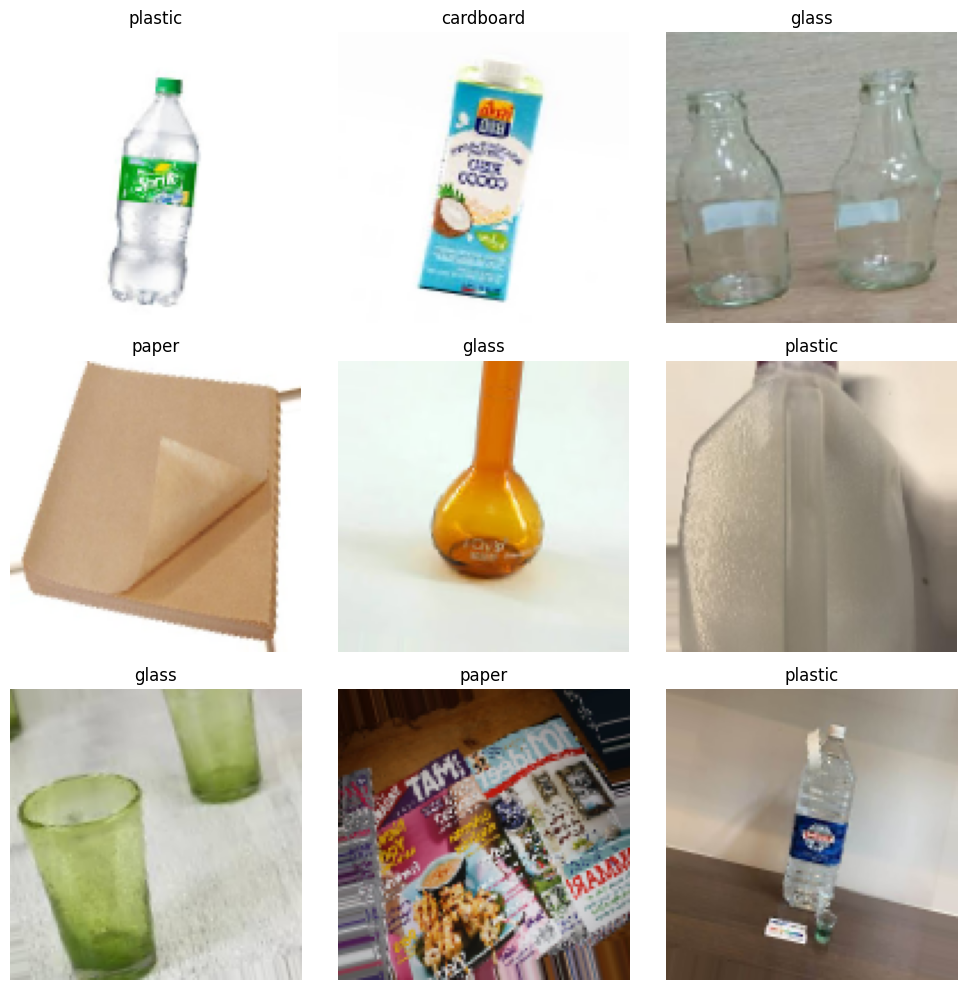

In [9]:
#Visualizing Dataset
class_names = list(train_data.class_indices.keys())

# Plot sample images
images, labels = next(train_data)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()

---

## <span style="color: red;">**5.1 - Comparing Dataset Distribution Methods**</span>

This section demonstrates the use of **limited batch sampling** to estimate class-wise distribution in training, validation, and test sets.  
It offers a **faster but approximate** alternative to full dataset scanning, which is useful for large datasets.
- Estimated class percentages for **Training**, **Validation**, and **Test** datasets  
- Visualized distributions using `matplotlib`  
- Calculated an **overall average** of train and validation sets  
- **Helps validate class balance before training**


### 📚 Libraries Used:
- `matplotlib.pyplot` : for visualizing class distribution using bar plots  
- `numpy` : for label decoding from batches  
- `dict.fromkeys()` : to initialize an empty class distribution dictionary  


### ⚙️ Functions Used:
- `count_distribution()` : calculates class-wise image proportions from a few batches  
- `simple_bar_plot()` : renders percentage bar plots for visual analysis  
- `round()` : formats percentages for readability  


⚡ Counting Batches:   0%|          | 0/327 [00:00<?, ?it/s]

⚡ Counting Batches:  37%|███▋      | 30/82 [00:04<00:07,  6.89it/s]


📊 Training:  {'cardboard': 18.85, 'glass': 25.94, 'metal': 10.62, 'paper': 16.88, 'plastic': 19.58, 'trash': 8.12}
🧪 Validation: {'cardboard': 16.56, 'glass': 26.77, 'metal': 9.9, 'paper': 18.65, 'plastic': 20.21, 'trash': 7.92}
🔍 Test:       {'cardboard': 0, 'glass': 0, 'metal': 0, 'paper': 0, 'plastic': 0, 'trash': 0}
📈 Overall:    {'cardboard': 17.7, 'glass': 26.36, 'metal': 10.26, 'paper': 17.77, 'plastic': 19.89, 'trash': 8.02}


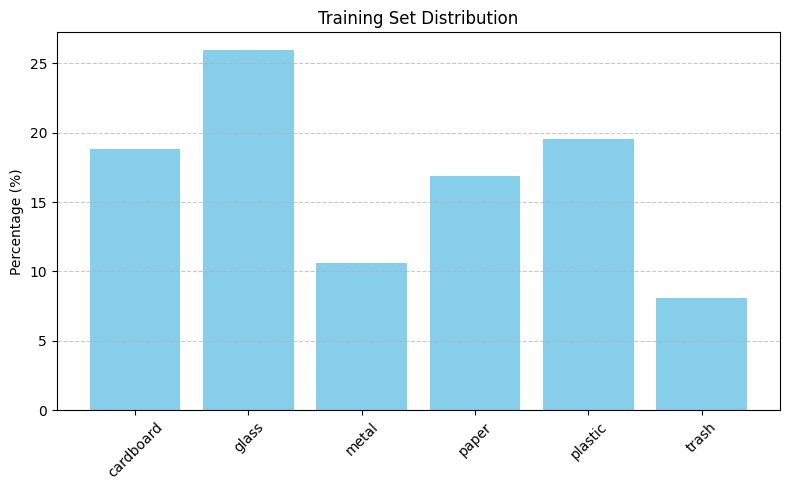

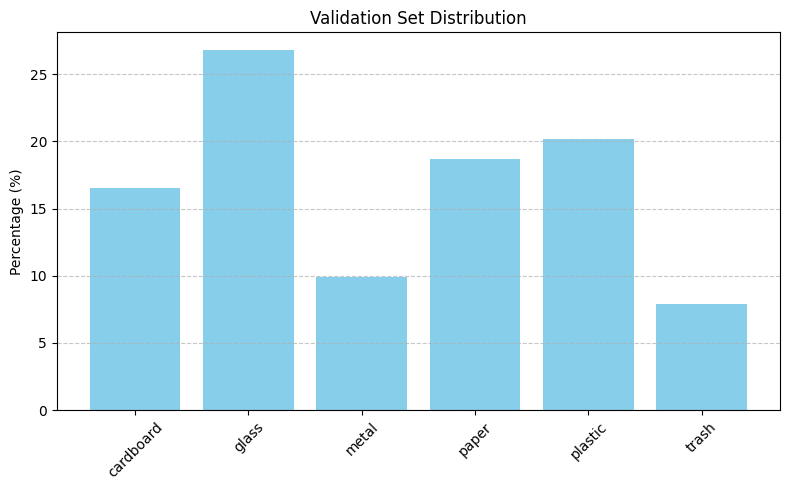

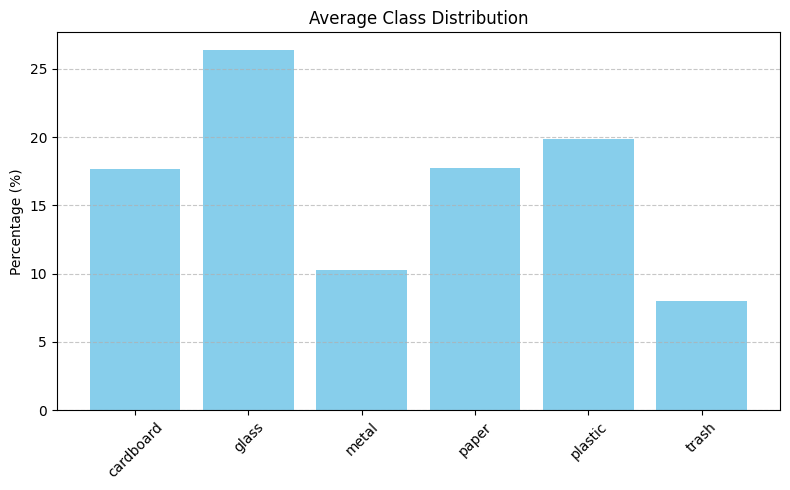

In [35]:
from tqdm import tqdm
import numpy as np

#  Toggle this for fast debugging or full run
FAST_MODE = True
MAX_BATCHES = 30 if FAST_MODE else None

#  Define function
def count_distribution(dataset, class_names, max_batches=None):
    total = 0
    counts = {name: 0 for name in class_names}

    for i, (images, labels) in enumerate(tqdm(dataset, desc="⚡ Counting Batches")):
        if max_batches and i >= max_batches:
            break
        for label in labels:
            class_name = class_names[np.argmax(label)]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)

    return counts

#  Class names
class_names = list(train_data.class_indices.keys())

#  Get distributions
train_dist = count_distribution(train_data, class_names, max_batches=MAX_BATCHES)
val_dist = count_distribution(val_data, class_names, max_batches=MAX_BATCHES)

#  Optional: use test_data if defined
try:
    test_dist = count_distribution(test_data, class_names, max_batches=MAX_BATCHES)
except:
    test_dist = dict.fromkeys(class_names, 0)

#  Average (train + val)
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

#  Print results
print("📊 Training: ", train_dist)
print("🧪 Validation:", val_dist)
print("🔍 Test:      ", test_dist)
print("📈 Overall:   ", overall_dist)

#  Visualize
simple_bar_plot(train_dist, "Training Set Distribution")
simple_bar_plot(val_dist, "Validation Set Distribution")
simple_bar_plot(overall_dist, "Average Class Distribution")
